# Predykcje dla 7 i 30 dni

## Import bibliotek

In [3]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Wczytanie i przygotowanie danych

In [5]:
df = pd.read_csv('../data/processed/energy_and_weather_data_for_model.csv', index_col='time', parse_dates=True)

In [6]:
pred_7 = df.loc['2018-12-25':'2018-12-31'].copy()
pred_30 = df.loc['2018-12-02':'2018-12-31'].copy()

features = ['temp', 'hour', 'dayofweek', 'month', 'load_rolling_3', 'temp_rolling_3']

X_pred_7 = pred_7[features]
X_pred_30 = pred_30[features]

## Wczytanie modelu

In [8]:
model = joblib.load('../model/model.pkl')

## Predykcje

### Predykcja 7- oraz 30-dniowa

In [11]:
pred_7['prediction'] = model.predict(X_pred_7)
pred_30['prediction'] = model.predict(X_pred_30)

### Zapis do pliku

In [13]:
pred_7[['total_load', 'prediction']].to_csv('../data/processed/pred_7_days.csv')
pred_30[['total_load', 'prediction']].to_csv('../data/processed/pred_30_days.csv')

## Wizualizacje

### Rzeczywiste dane vs predykcja

In [16]:
def plot_predictions(df_subset, title, save_path=""):
    plt.figure(figsize=(14,6))
    plt.plot(df_subset.index, df_subset['total_load'], label='Rzeczywiste zużycie', color='blue')
    plt.plot(df_subset.index, df_subset['prediction'], label='Predykcja modelu', color='orange', linestyle='--')
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Zużycie energii [MW]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

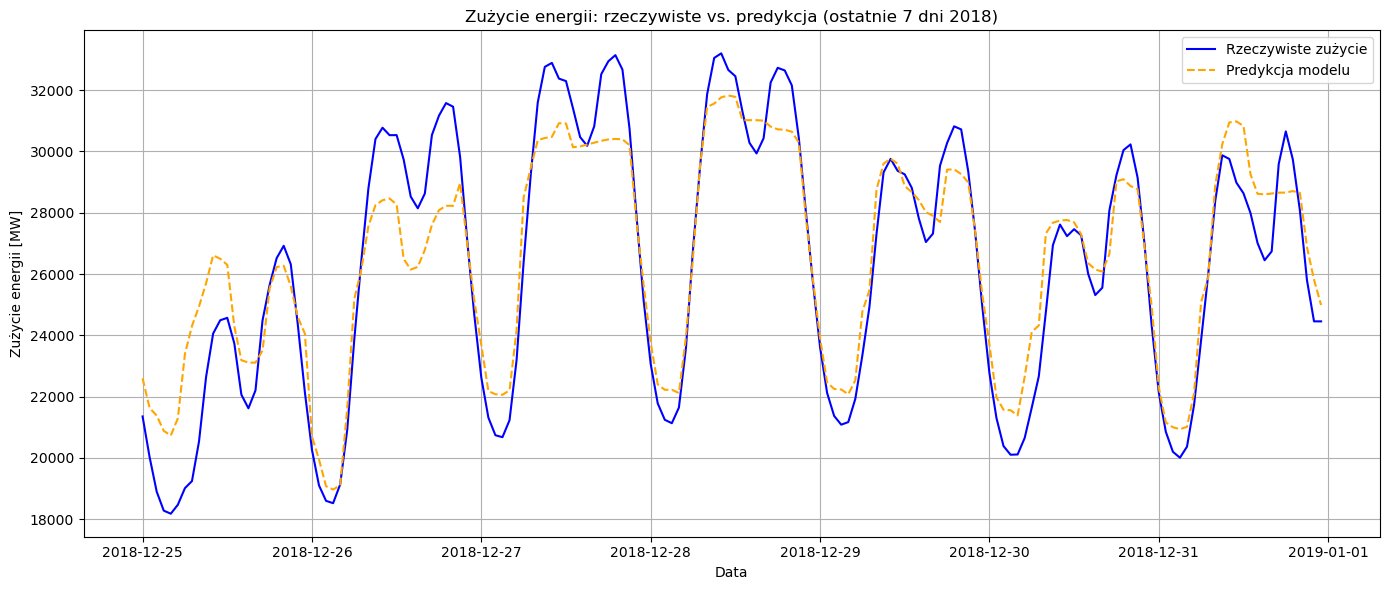

In [17]:
plot_predictions(pred_7, 'Zużycie energii: rzeczywiste vs. predykcja (ostatnie 7 dni 2018)', save_path='../plots/prediction_7_days.png')

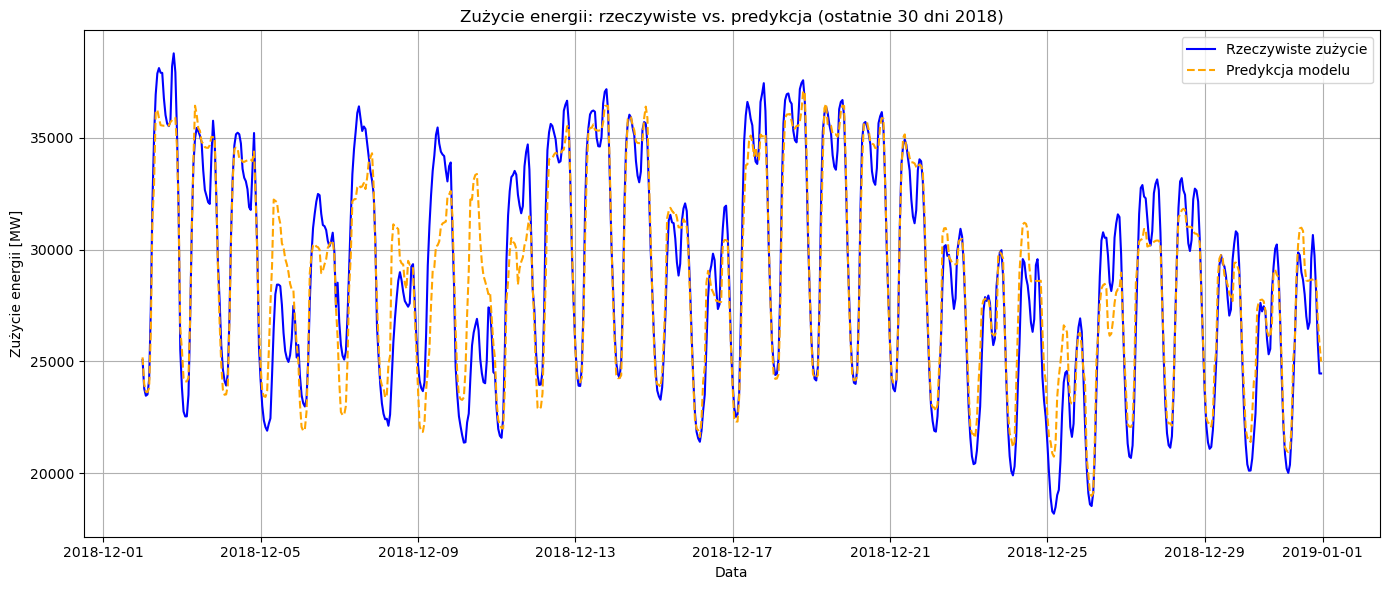

In [18]:
plot_predictions(pred_30, 'Zużycie energii: rzeczywiste vs. predykcja (ostatnie 30 dni 2018)', save_path='../plots/prediction_30_days.png')

### Rzeczywiste dane vs predykcja + zaznaczenie wpływu temperatury

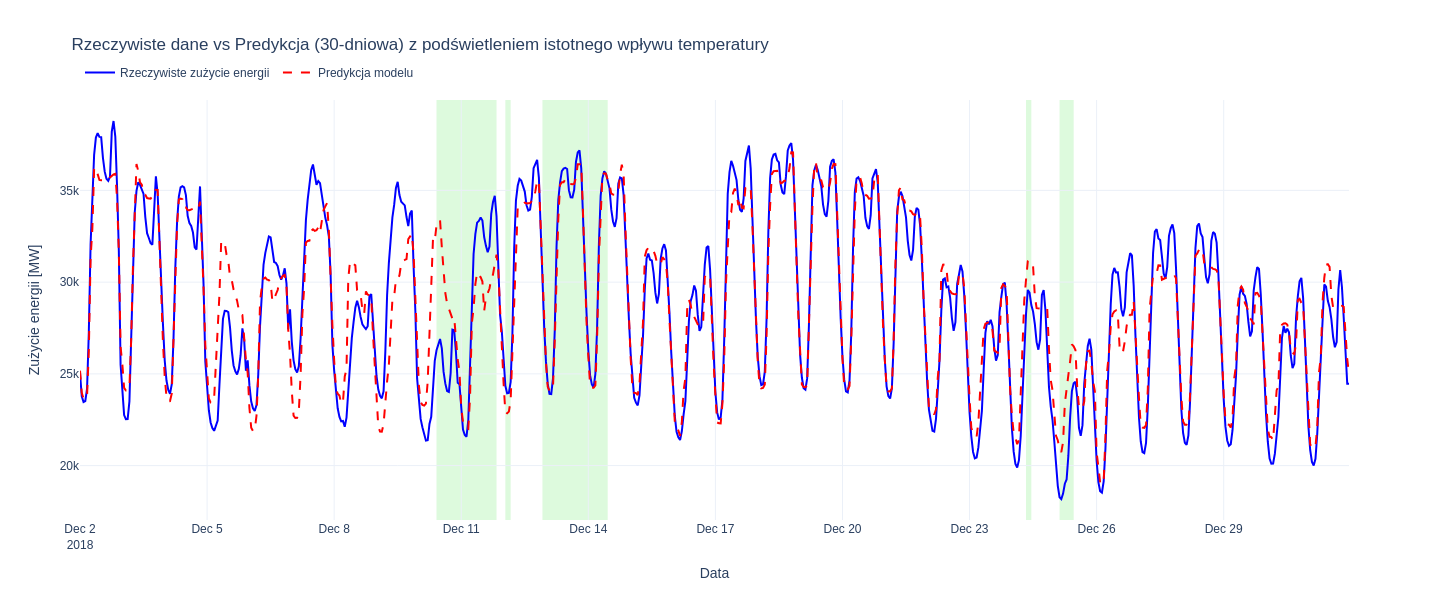

In [39]:
df = pred_30

# Parametry
window_size = 24 * 7  # 7 dni (dane godzinowe)
threshold = 0.4  # próg korelacji do uznania wpływu temperatury za istotny

# przesuwna korelacja temperatury z zużyciem energii
df['temp_load_corr'] = df['total_load'].rolling(window=window_size).corr(df['temp'])

# okresy, gdzie korelacja jest istotna (absolutna wartość większa niż threshold)
df['high_corr'] = df['temp_load_corr'].abs() > threshold

# grupowanie - ciągłe okresy wysokiej korelacji
df['group'] = (df['high_corr'] != df['high_corr'].shift()).cumsum()

periods = df[df['high_corr']].groupby('group').agg(
    start=('temp_load_corr', 'idxmin'),
    end=('temp_load_corr', 'idxmax')
).reset_index(drop=True)

# Rysowanie wykresu
fig = go.Figure()

# Wykres rzeczywistych danych
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['total_load'],
    mode='lines',
    name='Rzeczywiste zużycie energii',
    line=dict(color='blue')
))

# Wykres predykcji
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['prediction'],
    mode='lines',
    name='Predykcja modelu',
    line=dict(color='red', dash='dash')
))

# Podświetlanie okresów wysokiej korelacji
for _, row in periods.iterrows():
    start = row['start']
    end = row['end']
    
    # jeśli okres poza zakresem indeksu
    if start > df.index[-1] or end < df.index[0]:
        continue
    
    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=max(start, df.index[0]),
        x1=min(end, df.index[-1]),
        y0=0,
        y1=1,
        fillcolor="LightGreen",
        opacity=0.3,
        layer="below",
        line_width=0,
    )
    
    # adnotacja
    mid_point = max(start, df.index[0]) + (min(end, df.index[-1]) - max(start, df.index[0])) / 2
    fig.add_annotation(
        x=mid_point,
        y=1.05,
        yref="paper",
        showarrow=False,
        font=dict(color="green"),
        bgcolor="white",
        text=""
    )

fig.update_layout(
    title="Rzeczywiste dane vs Predykcja (30-dniowa) z podświetleniem istotnego wpływu temperatury",
    xaxis_title="Data",
    yaxis_title="Zużycie energii [MW]",
    legend=dict(x=0, y=1.1, orientation="h"),
    template="plotly_white",
    height=500
)
# Aktualizacja rozmiaru wykresu
width = 1200
height = 600
fig.update_layout(
    width=width,
    height=height
)
fig.write_image("../plots/prediction_30_days_with_temperature.png", width=width, height=height)
fig.show()